In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.max_rows = 8  
%matplotlib inline

import os, sys
import statsmodels, arch

print(sys.version)
print('statsmodels version: ',statsmodels.__version__, 
    '; arch version: ', arch.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
statsmodels version:  0.12.0 ; arch version:  4.19


读取数据

In [75]:
national_debt = pd.read_csv('data/national_debt_5y.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


,开盘,收盘,高,低,涨跌幅
count,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03
mean,3.041862,3.022280,3.049060,3.010074,4.478567e-07
std,0.419688,0.420101,0.418939,0.420670,9.475657e-03
min,1.740000,1.740000,1.740000,1.740000,-5.850000e-02
25%,2.746000,2.712000,2.750000,2.697000,-4.350000e-03
50%,3.012000,2.993000,3.018000,2.983000,0.000000e+00
75%,3.261000,3.234000,3.269000,3.219000,4.300000e-03
max,4.000000,3.968000,4.000000,3.952000,6.070000e-02


单位根检验

In [76]:
from arch.unitroot import ADF
print(ADF(national_debt.开盘))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.162
P-value                         0.220
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


p-value大于0.1，拒绝了序列 x 的平稳性。

In [77]:
#可以看到序列自相关性是很高的，从序列表现来看也不够平稳性，所以需要做一阶差分
data = pd.Series(np.diff(national_debt.开盘))
#data = pd.Series.diff(national_debt.开盘)
print("data length is %d",len(data))

print(ADF(data))

data length is %d 1562
   Augmented Dickey-Fuller Results   
Test Statistic                 -6.791
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


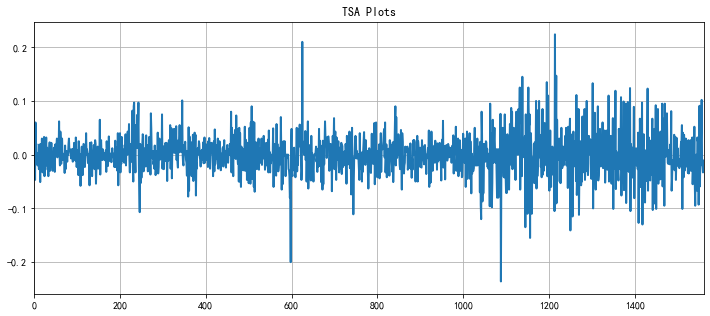

In [78]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

data.plot(use_index=False,figsize=(12,5),linewidth=2,grid=True,title = "TSA Plots")
plt.show()

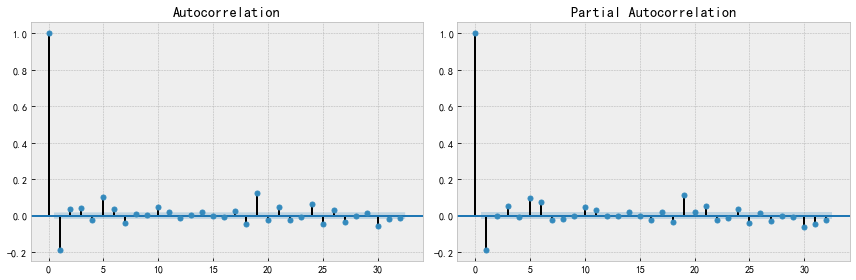

In [79]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

from scipy import stats
from arch.unitroot import ADF

def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
      
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
         
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        plt.tight_layout()

tsplot(data)

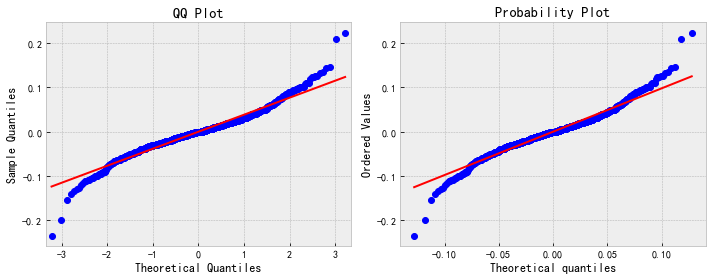

In [80]:
def tsplot2(y, lags=None, figsize=(10,4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
        qq_ax = plt.subplot2grid(layout, (0, 0))
        pp_ax = plt.subplot2grid(layout, (0, 1))
        
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()

tsplot2(data)

QQ plot（quantile-quantile plot），也称正态概率图（normal probability plot），分位数-分位数图,是常用的统计分析用图，
用于检查一组数据是否服从正态分布，是实数与正态分布数据间的函数关系的散点图。
如果这组实数服从正态分布，正态概率图就是一条直线。通常，概率图也可用于确定一组数据是否服从任一已知分布，如二项分布或泊松分布。

p–p图绘制两个累积分布函数（CDF）的相对位置：这是一个概率图，用于评估两个数据集之间的一致程度，
并绘制两个累积分布函数的相对位置。P-P图被广泛用于评估分布的偏斜度。

截尾是指时间序列的自相关函数（ACF）或偏自相关函数（PACF）在某阶后均为0的性质，在大于某个常数k后快速趋于0为k阶截尾；

拖尾是ACF或PACF并不在某阶后均为0的性质，始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动)。

AR模型：自相关系数拖尾，偏自相关系数截尾；

MA模型：自相关系数截尾，偏自相关函数拖尾；

ARMA模型：自相关函数和偏自相关函数均拖尾。


## ARMA 模型

In [81]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

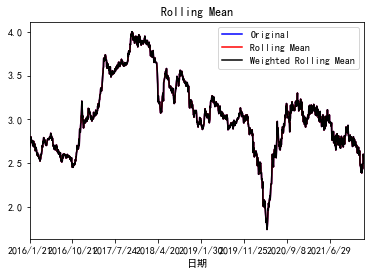

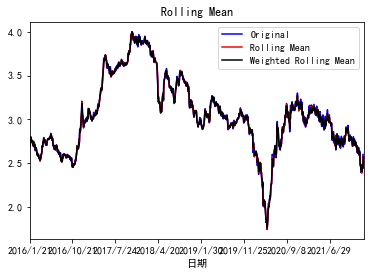

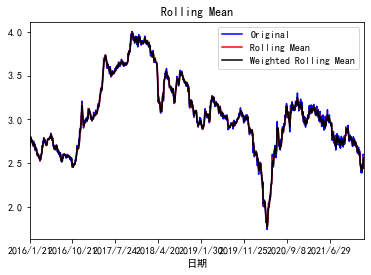

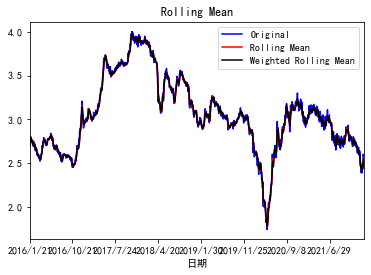

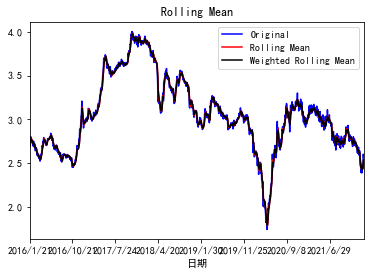

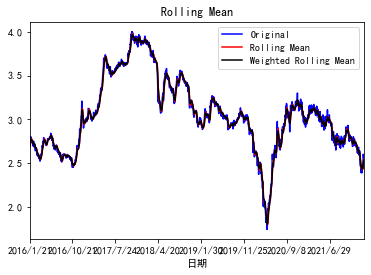

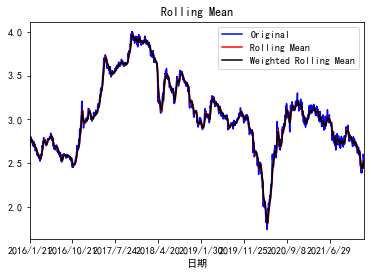

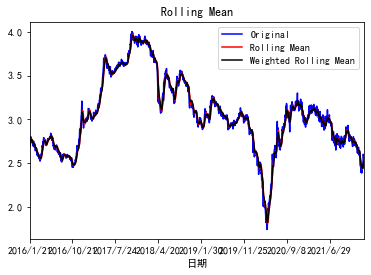

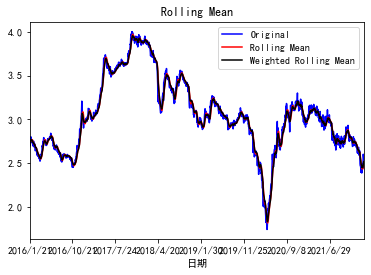

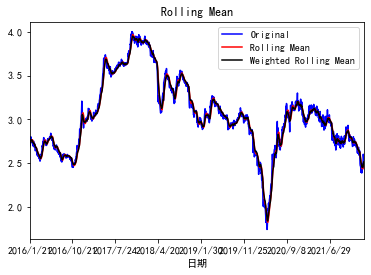

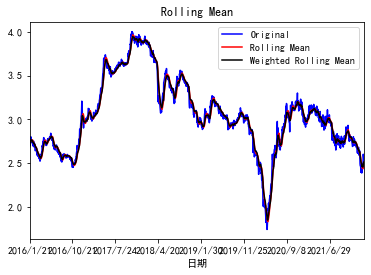

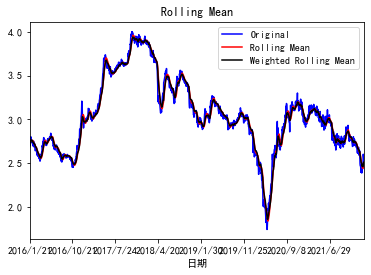

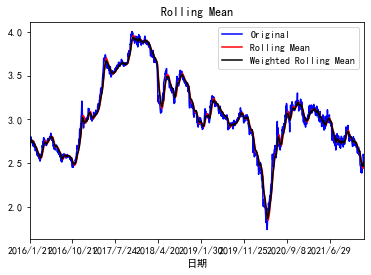

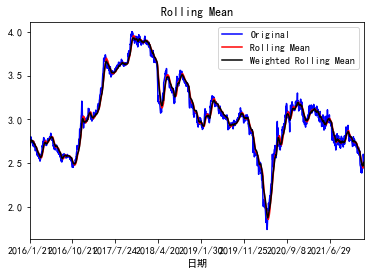

In [82]:
for i in range(1,15):
    
    draw_trend(national_debt.开盘, i)


In [116]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    print(dftest)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

ts_log = np.log(national_debt.开盘)
rol_mean = ts_log.rolling(window=5).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

(-6.954276022571542, 9.51725324866186e-10, 24, 1533, {'1%': -3.4346228529495666, '5%': -2.8634272008756785, '10%': -2.5677747177787733}, -13627.07659273149)


Test Statistic                -6.954276e+00
p-value                        9.517253e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.533000e+03
Critical Value (1%)           -3.434623e+00
Critical Value (5%)           -2.863427e+00
Critical Value (10%)          -2.567775e+00
dtype: float64

差分后，ADF检验中p值为0.000小于0.05，故而差分后序列平稳。

白噪声检验

In [117]:
from statsmodels.stats.diagnostic import acorr_ljungbox
res = acorr_ljungbox(ts_diff_1, lags=[6,12,24], return_df=True)
print(res)

        lb_stat  lb_pvalue
6   2191.278322        0.0
12  2277.546145        0.0
24  2463.024298        0.0


各滞后期数下p值都为0均小于0.05，差分后的序列非白噪声，可以进行预测。

In [131]:
from statsmodels.tsa.stattools import arma_order_select_ic
bic_min_order = arma_order_select_ic(ts_diff_1, max_ar=6, max_ma=5, ic='bic')['bic_min_order']
print(bic_min_order)

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

(1, 4)


D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [132]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order=(1, 4)) 
result_arma = model.fit(disp=-1, method = 'CSS') 

result_arma.summary()

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     开盘   No. Observations:                 1558
Model:                     ARMA(1, 4)   Log Likelihood                6984.428
Method:                           css   S.D. of innovations              0.003
Date:                Mon, 04 Apr 2022   AIC                         -13954.857
Time:                        16:51:36   BIC                         -13917.403
Sample:                             1   HQIC                        -13940.930
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.404      0.160      -0.000       0.001
ar.L1.开盘      -0.1451      0.026     -5.549      0.000      -0.196      -0.094
ma.L1.开盘       0.9613      0.010     99.414      0.000       0.942       0.980
ma.L2.开盘       0.9558      0.011     85.239      0.000       0.934       0.978
ma.L3.开盘       0.9559      0.011     85.537      0.000       0.934       0.978
ma.L4.开盘       0.9305      0.010     90.419      0.000       0.910       0.951
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.8924           +0.0000j            6.8924            0.5000
MA.1            0.3155           -0.9609j            1.0113           -0.1995
MA.2            0.3155           +0.9609j            1.0113            0.1995
MA.3           -0.8291           -0.6027j            1.0250           -0.4000
MA.4           -0.8291           +0.6027j            1.0250            0.4000
-----------------------------------------------------------------------------
"""

系数p值均小于0.05，说明系数均显著不为0。如果存在某个系数的p值较大，说明t检验中系数不显著，贡献不大，可以剔除，减小模型冗余度。

In [133]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)

# 移动平均还原
rol_sum = ts_log.rolling(window=4).sum()
rol_recover = diff_recover*5 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)
print("the length of log_recover is %d ",len(log_recover))

the length of log_recover is %d  1557


这里的数据相比较原始数据的1563少了6个，原因是一位用来做差分，5位用来计算移动平均

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

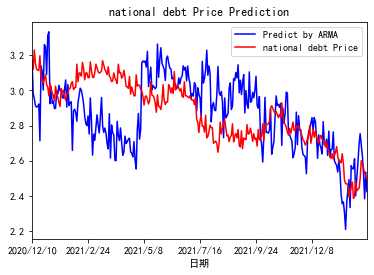

In [134]:
plt.figure(facecolor='white')
log_recover[len(log_recover) - 300:].plot(color='blue', label='Predict by ARMA')
pd.Series(national_debt.开盘[len(national_debt.开盘)-300:]).plot(color='red', label='national debt Price')
plt.legend(loc='best')
plt.title('national debt Price Prediction')
plt.show()

In [135]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(log_recover,national_debt.开盘[6:])
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(log_recover, national_debt.开盘[6:]))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(log_recover, national_debt.开盘[6:])
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.138911
均方根误差: 0.372707
平均绝对误差: 0.275812
